"When not dealt with proactively, fraud can affect companies' bottom lines by pulling resources from the core business and priorities, damaging brand reputation, and squandering profits." (cobwebs.com 2021)

In [158]:
import torch
import pandas as pd 
import numpy as np


In [159]:
df = pd.read_csv(r'/Users/williamfry/Fraud Detection/FraudData.csv')


In [129]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [130]:
df.shape

(6362620, 11)

For this project i am using the Synthetic Financial Datasets For Fraud Detection available on kaggle at "https://www.kaggle.com/datasets/ealaxi/paysim1" the head of this data is shown above.

The column step maps a real world unit of time with one step representing one hour of time
the other columns show infomation you would expect to see in transaction data: the type of payment, the amount, the orgin and destination of the payment represented with a code, if the code starts woth the letter 'c' then that is a customer, 'm' represents merchant. Also the old and new balence of the destination account, and if the transaction was fraud or was flagged for fraud.

number of fraudulent transactions:  8213
number of transactions flagged as fraud:  16
number of transactions:  6362620


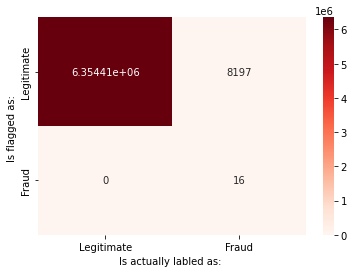

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


#Function to create a fancier confusion matrix using seaborn
def confusionMatrix(y_test,y_pred):
    matrix =  confusion_matrix(y_test, y_pred)
    ax= plt.subplot()
    heat = sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap='Reds')
    ax.xaxis.set_ticklabels(lables)
    ax.yaxis.set_ticklabels(lables)
    ax.set_xlabel('Is actually labled as: ')
    ax.set_ylabel('Is flagged as: ')
    return heat

isFraud = df['isFraud']
isFlagged = df['isFlaggedFraud']
lables = ['Legitimate', 'Fraud']

confusionMatrix(isFlagged, isFraud)

print('number of fraudulent transactions: ', sum(isFraud))
print('number of transactions flagged as fraud: ',sum(isFlagged))
print('number of transactions: ', len(isFlagged))



The confusion matrix above compares the two columns in the dataset isFraud and isFlaggedFraud,
The vast majority of the dataset if formed of legitimate transactions,
The pervious model flags 6,354,391 transactions correctly as being legitimate,
Only 16 out of the 8213 fraudulent transactions as being fradulent.
The model does not incorrectly lable any legitimate transactins as fraud
Due to this we need to train a neural network to do a better job at flagging fraudulent transactions

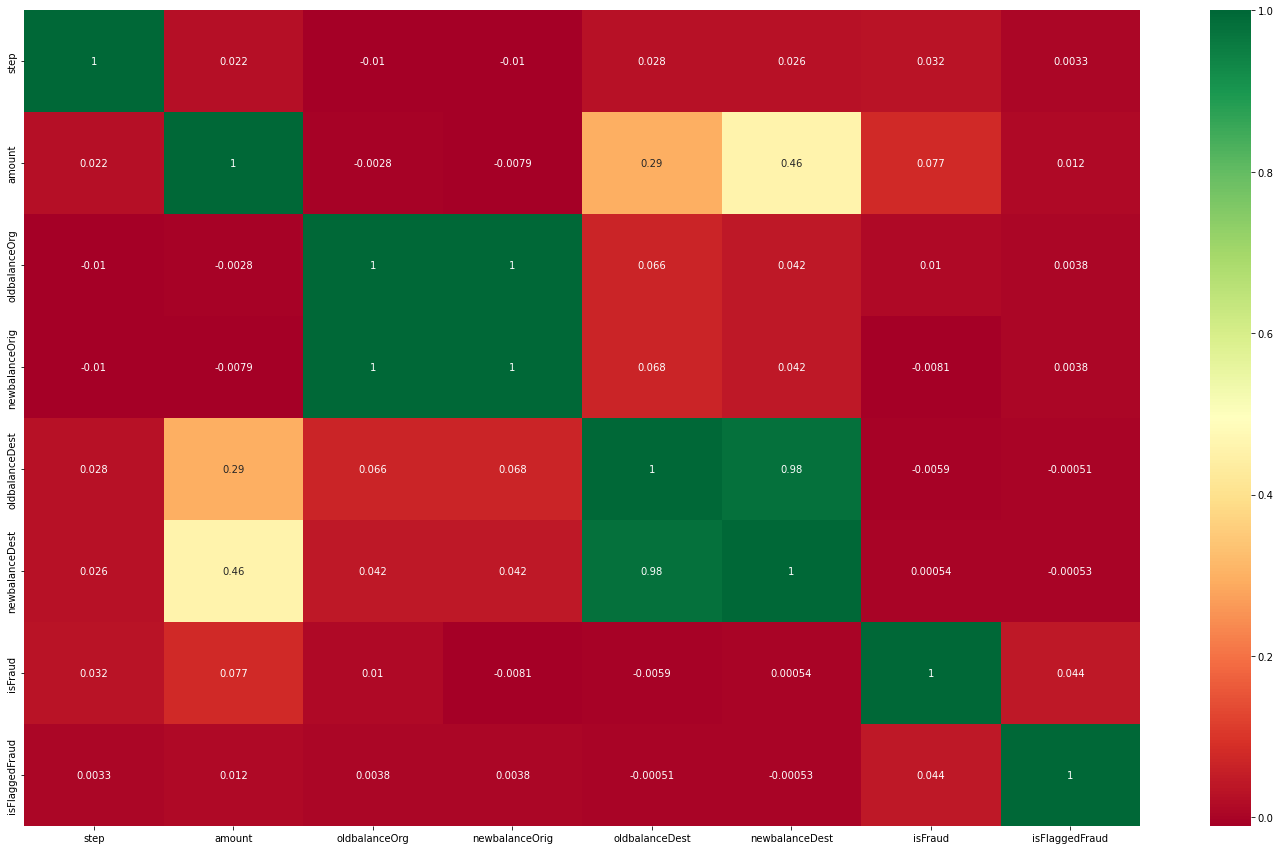

In [132]:
corr = df.corr()

plt.figure(figsize=(25, 15))
sns.heatmap(corr, annot=True, cmap='RdYlGn')
plt.show()

This corrilation plot shows the relationships between each of the different x variables, from this we can see that there os a very strong corrilation between oldbalanceOrg and newbalanceOrg and also oldbalenceDest and newbalanceDest, to avoid overcpmplicating the model tone of each of these pairs will be removed. Before we remove these columns we must first calculate any discrepancies between the balences of the accounts before and after the transaction, as this could be a marker for fraud. 

In [133]:
df['origBalance_inacc'] = (df["oldbalanceOrg"] - df["amount"] != df["newbalanceOrig"]).astype(int)
df['destBalance_inacc'] = (df["oldbalanceDest"] + df["amount"] != df["newbalanceDest"]).astype(int)
#Removing the parts of the dataset we don't actually need
df = df.drop(['step', 'nameOrig', 'nameDest', 'oldbalanceOrg', 'oldbalanceDest', 'isFlaggedFraud'], axis = 1)
df.head()

,type,amount,newbalanceOrig,newbalanceDest,isFraud,origBalance_inacc,destBalance_inacc
0,PAYMENT,9839.64,160296.36,0.0,0,0,1
1,PAYMENT,1864.28,19384.72,0.0,0,0,1
2,TRANSFER,181.00,0.00,0.0,1,0,1
3,CASH_OUT,181.00,0.00,0.0,1,0,1
4,PAYMENT,11668.14,29885.86,0.0,0,0,1


In [134]:
paytype = []
for i in df['type']:
    if i == "PAYMENT":
        paytype.append(1)
    if i == "TRANSFER":
        paytype.append(2)
    if i == "CASH_OUT":
        paytype.append(3)
    if i == "DEBIT":
        paytype.append(4)
    if i == "CASH_IN":
        paytype.append(5)
df['type'] = paytype
df.head()

,type,amount,newbalanceOrig,newbalanceDest,isFraud,origBalance_inacc,destBalance_inacc
0,1,9839.64,160296.36,0.0,0,0,1
1,1,1864.28,19384.72,0.0,0,0,1
2,2,181.00,0.00,0.0,1,0,1
3,3,181.00,0.00,0.0,1,0,1
4,1,11668.14,29885.86,0.0,0,0,1


In [135]:
fraud = df['isFraud']
df = df.drop(['isFraud'], axis = 1)
df['isFraud'] = fraud 
df

,type,amount,newbalanceOrig,newbalanceDest,origBalance_inacc,destBalance_inacc,isFraud
0,1,9839.64,160296.36,0.00,0,1,0
1,1,1864.28,19384.72,0.00,0,1,0
2,2,181.00,0.00,0.00,0,1,1
3,3,181.00,0.00,0.00,0,1,1
4,1,11668.14,29885.86,0.00,0,1,0
...,...,...,...,...,...,...,...
6362615,3,339682.13,0.00,339682.13,0,0,1
6362616,2,6311409.28,0.00,0.00,0,1,1
6362617,3,6311409.28,0.00,6379898.11,0,1,1
6362618,2,850002.52,0.00,0.00,0,1,1


In the box above we have added two new columns showing the discrepancies between the account balances and we have also removed the irrilevant coulums that are not going to be useful with the classification.

now its time to prepare the data for training the neural network we do this by splitting off the fraud column from the rest of the data then performing the train test split

In [136]:
X = df.iloc[:, 0:6].values  # Input values.
y = df.iloc[:, 6].values    # Output values(species categories)


In [137]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, random_state=0)

As we are using pytroch for out neural network we now need to convert the data into tensors

In [139]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

We now need to define the neural network class and initialize our network model

In [140]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNet(nn.Module):
    def __init__(self, in_features=6, out_features=3):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=out_features)
        
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        return self.fc3(X)

In [141]:
model = NeuralNet()

We now need to ajust the weights of the two classes in our cross entrophy loss calculations this is because in the dataset we have far more legitimate transactions than fraud

In [146]:
weights = [6362619/6354407, 6362619/8213, 0]
weights = torch.FloatTensor(weights)
criterion = nn.CrossEntropyLoss(weight = weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

We now need to train the model we will use 50 epochs as the dataset is very large

In [152]:
epochs = 50
losses = []
for i in range(epochs):
    i += 1
    
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    
    losses.append(loss)
    
    if i % 10 == 0:
        print(f'epoch: {i} -> loss: {loss}')
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch: 10 -> loss: 2354.13037109375
epoch: 20 -> loss: 570.4214477539062
epoch: 30 -> loss: 321.95794677734375
epoch: 40 -> loss: 177.938232421875
epoch: 50 -> loss: 429.13201904296875


Now we create a plot to show the change in loss over generations of the model

In [153]:
lossForPlot = []
j = 0
for i in losses:
    if j >= 0:
        lossForPlot.append(i.item())
    j+=1

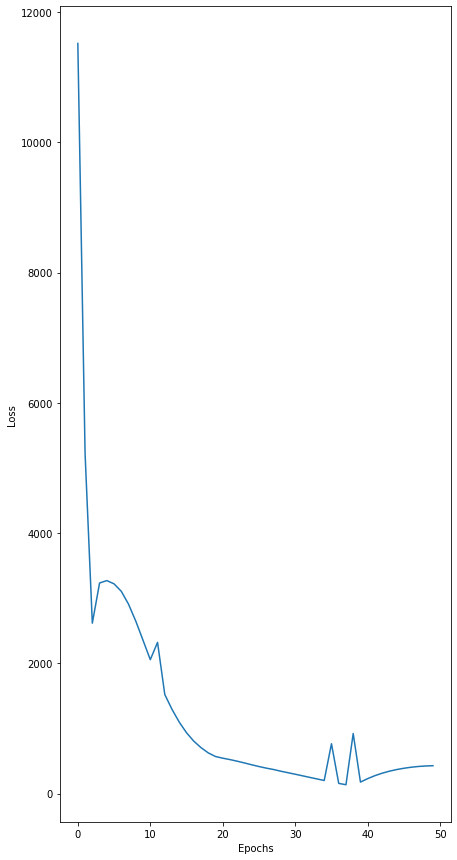

In [154]:
plt.figure(figsize=(7, 15))
plt.plot(lossForPlot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Now we need to test the performance of the model for this we will calculate predicted y values to compare to the test y data, and display the results in a confusion matrix.

In [155]:
with torch.no_grad():
    y_pred = model(X_test)
    preds = torch.max(y_pred, dim=1)[1]
    correct = (preds == y_test).sum()
    
print(f'{correct} out of {y_test.shape[0]} is correct : {correct.item() / y_test.shape[0] * 100}%')

892010 out of 1272524 is correct : 70.09769560338351%


<AxesSubplot:xlabel='Is actually labled as: ', ylabel='Is flagged as: '>

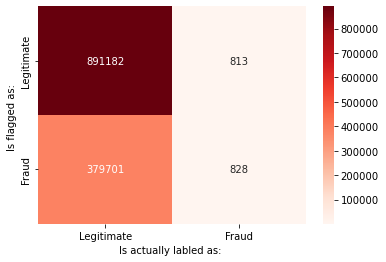

In [156]:
confusionMatrix(preds, y_test)